In [1]:
from sklearn.cluster import KMeans
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
import json
#https://towardsdatascience.com/spectral-clustering-aba2640c0d5b

In [158]:
def makeCircleGraph():
    G=nx.Graph()
    G.add_edge(0,1)
    G.add_edge(0,2)
    G.add_edge(0,5)
    G.add_edge(0,8)
    G.add_edge(0,9)
    G.add_edge(1,2)
    G.add_edge(3,4)
    G.add_edge(3,5)
    G.add_edge(4,5)
    G.add_edge(5,6)
    G.add_edge(5,7)
    G.add_edge(6,7)
    G.add_edge(8,9)
    return G
def makeGraph2():
    G=nx.Graph()
    G.add_edge(0,1,weight=0.8)
    G.add_edge(0,2,weight=0.6)
    G.add_edge(0,3,weight=0.1)
    
    G.add_edge(1,2,weight=0.9)
    G.add_edge(2,5,weight=0.2)
    
    G.add_edge(3,4,weight=0.6)
    G.add_edge(3,5,weight=0.7)
    
    G.add_edge(4,5,weight=0.8)
    return G
    
def drawGraph(G,cluster=None,lineWidth=3,node_size=500,seed=None,minLine=1,maxLine=6,drawLabel=False,drawAllNode=False):
    '''
    G:图对象
    cluster:对定点的分类结果,cluser[nodeId]表示类别
        cluster不是空,只有相同类型顶点之间才会画上边
    
    '''
    
    
    pos = nx.spring_layout(G,seed=seed)  # positions for all nodes
    colors=['#ff6666','#B03060',,'#EEAD0E','#ccff00','#8B7500','#912CEE','#B03060''#8B7500','#912CEE','#B03060',
            '#B03060','#cc0066','#99ff66','#990033','#666633',
            '#660099','#EEAD0E','#D1EEEE','#48D1CC','#030303','#8B0000',
            '#8B7500','#912CEE','#B03060']
    plt.figure(figsize=(10, 10))
    #有边长的
    nodelist=set([nodeId for nodeId,adj in G.adjacency() if len(adj)>0])
    
    if cluster is not None:
        groups=defaultdict(list)
        #draw node
        for node in G.nodes:
            if not drawAllNode:
                if node not in nodelist:continue
            c=cluster[node]
            nx.draw_networkx_nodes(G,pos,nodelist=[node],node_color=colors[c],node_size=node_size,alpha=0.8)
        #draw edge
        for u,v,_ in G.edges(data=True):
            if cluster[u]==cluster[v]:
                groups[cluster[u]].append((u,v))
        for c,edgelist in groups.items():
            nx.draw_networkx_edges(G,pos,edgelist,width=lineWidth,edge_color=colors[c],alpha=0.5)
        #画群的标注
        K=np.max(labels)+1
        for i in range(K):
            plt.plot([], marker='x', label='C:'+str(i),c=colors[i])
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    else:
        if not drawAllNode:
            nx.draw_networkx_nodes(G, pos,nodelist=nodelist,node_size=node_size,alpha=0.8)
        else:
            nx.draw_networkx_nodes(G, pos,node_size=node_size,alpha=0.8)
        #求出最小权重与最大权重
        minW,maxW=float('inf'),-1
        for u,v,d in G.edges(data=True):
            d=d['weight']
            if d>maxW:
                maxW=d
            if d<minW:
                minW=d
        #  线宽正比于权重
        for u,v,d in G.edges(data=True):
            d=d['weight']
            if minW==maxW:
                linesize=minLine
            else:
                linesize=minLine+maxLine*(d-minW)/(minW-maxW)
            nx.draw_networkx_edges(G,pos,[(u,v)],alpha=0.4,width=linesize)
    # labels
    if drawLabel:
        nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axis('off')
    plt.show()
    return pos

SyntaxError: invalid syntax (<ipython-input-158-42cd1b5efc0d>, line 42)

In [159]:
def graph2Matrix(G,indexFunc=None):
    '''
    根据G,返回一个邻接矩阵,A[i][j]表示从node i 到 node j的weight
    indexFunc:索引转换函数,把图G的 "节点名字" 转成 矩阵的 "下标索引"
    如果为None,"节点名字" 就必须是 矩阵的 "下标索引"
    '''
    n=len(G.nodes)
    A=np.zeros((n,n))
    for nodeIdx,adj in G.adjacency():
        for adjIdx,w in adj.items():
            s,t= (indexFunc[nodeIdx],indexFunc[adjIdx]) if indexFunc else (nodeIdx,adjIdx)    
            A[s,t]=w['weight'] if 'weight' in w else 1
    return A
def LaplacianMatrix(A):
    '''
    传入邻接矩阵,A[i][j]表示从node i 到 node j的权重
    计算degress D,返回L=D-A
    '''
    D=np.diag(A.sum(axis=1))
    return D-A

def eig(L):
    '''
    计算L的特征值和特征向量,并按照升序排列
    返回S:r特征值
       V:n,r特征向量
    '''
    S,V=np.linalg.eig(L)
    sortIndex=np.argsort(S)
    S=S[sortIndex].real
    V=V[:,sortIndex].real
    return S,V
def proposalCluster(S,eps=0.2):
    '''
    
        eps:当某个特征值与他临近的差值大于eps时,
        这个特征值就是一个分界点,特征值的索引+1表示应该分类
        的个数
        
        返回建议分的类别,并且取出相应的
        特征,进行返回K
        
        
    '''
    
    K=1+np.where(S<eps)[0][-1]
    return K
def getCluster(K,eigValues):
    '''
    提取特征eigValues[:,1:K],然后运行分类算法
    '''
    features=eigValues[:,1:K]
    model=KMeans(n_clusters=K)
    model.fit(features)
    return model.labels_
    

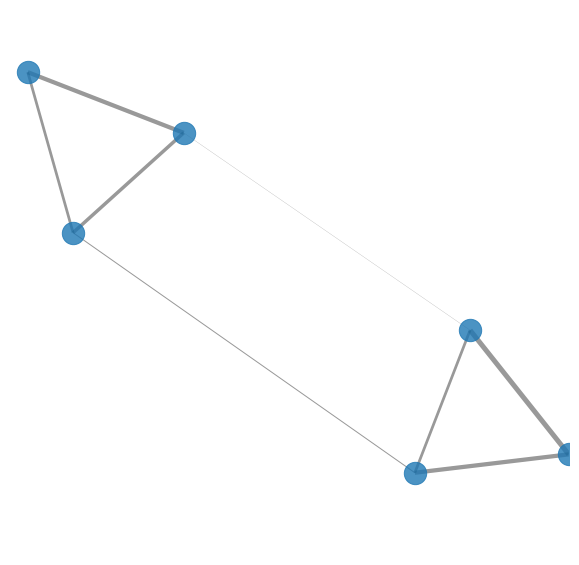

classes: 2


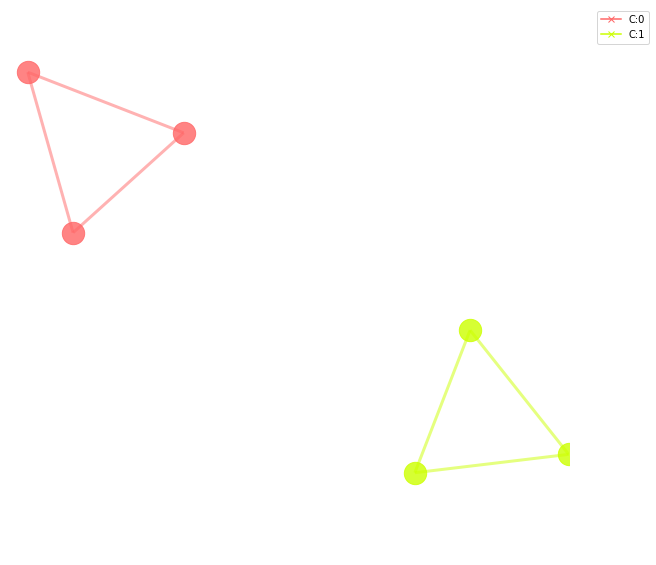

{0: array([ 0.4485361 , -0.69988939]),
 1: array([ 1.        , -0.63229038]),
 2: array([ 0.64652797, -0.17550404]),
 3: array([-0.77640539,  0.18326889]),
 4: array([-0.93884793,  0.77377296]),
 5: array([-0.37981075,  0.55064195])}

In [160]:
plt.figure()
seed=1000


G=makeGraph2()
drawGraph(G,lineWidth=3,seed=seed)

L=LaplacianMatrix(graph2Matrix(G))
S,V=eig(L)
K=proposalCluster(S,0.2)
print('classes:',K)
labels=getCluster(K,V)
plt.figure()
drawGraph(G,labels,lineWidth=3,seed=seed)

### 话单数据

#节点数量 383 383
#边数量 841


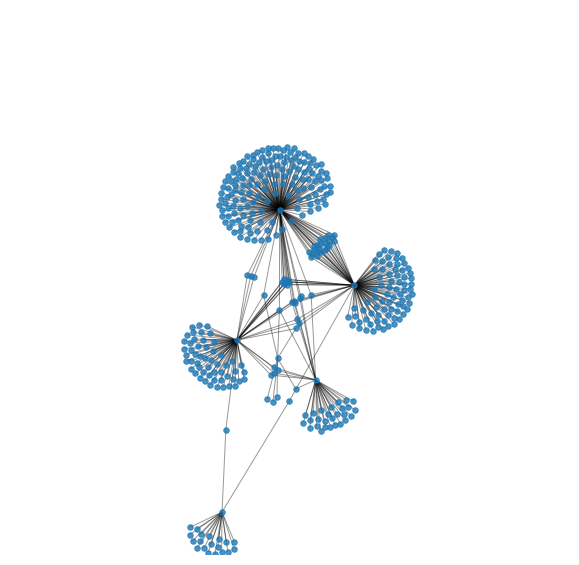

In [161]:
seed=0
def makeChengfGraph(filepath):
    with open(filepath) as fp:
        jsonObj=json.load(fp)
    nodes=[]
    for node in jsonObj['nodes']:
        pid=node['id']
        nodes.append(pid)
    
    #创建关系图
    nodename=set()
    for edge in jsonObj['edges']:
        s=edge['source']
        t=edge['target']
        nodename.add(s)
        nodename.add(t)
        
    Id2Index={phone:i for i,phone in enumerate(nodename)}
    Index2Id={v:k for k,v in Id2Index.items()}
    
    G=nx.Graph()    
    edgenum=0
    for edge in jsonObj['edges']:
        s=edge['source']
        t=edge['target']
        sid=Id2Index[s]
        tid=Id2Index[t]
        G.add_edge(sid,tid,weight=1.0)
        edgenum+=1
        
    print('#节点数量',len(Id2Index),len(Index2Id))
    print('#边数量',edgenum)
    return G,Id2Index,Index2Id
G,Id2Index,Index2Id=makeChengfGraph('data/15609142632702.json')
pos=drawGraph(G,cluster=None,node_size=30,seed=seed)

classes: 5


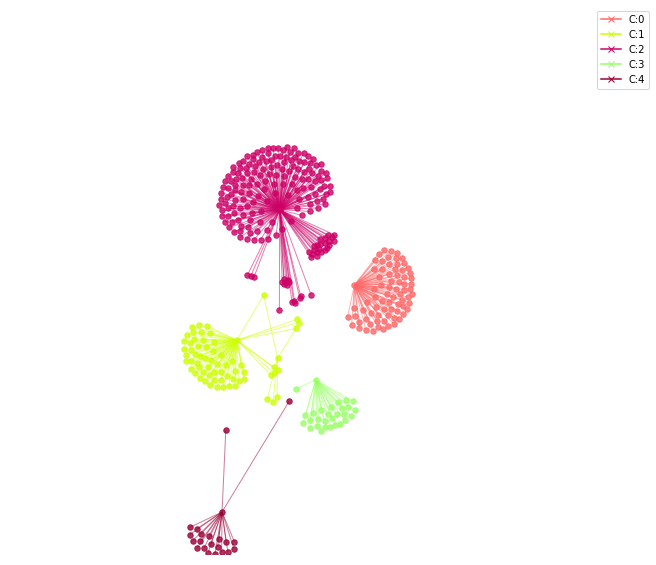

In [167]:
L=LaplacianMatrix(graph2Matrix(G))
S,V=eig(L)
K=proposalCluster(S,0.4)
print('classes:',K)
labels=getCluster(K,V)
pos=drawGraph(G,labels,lineWidth=1,node_size=30,seed=seed)

### 根据分类提取出子图,然后可以对子图进行rank

In [168]:
from collections import defaultdict
def get_subGraph(G,labels):
    '''
    G:要求节点名称是0开始的索引,与labels相对于,也就是说
    labels[node'i name]表示node i的分类
    
    labels:G节点 聚类的结果,numpy array
    
    返回:cluster=dict
    key:分组名称
    value:dict{
        graph:构建的子图,子图节点使用的名字继承自父图G
        2index:子图 "节点名称" 与 "子图节点" 的对应字典,全局 到 局部 ,名字 到 索引
        index2:局部 到 全局, 索引 到 名字,
    }
    '''
    
    #clusters:key=classname,value=list of edges(s,t,w)
    clutsers=defaultdict(list)
    for n1,adj in G.adjacency():
        for n2,w in adj.items():
            c1,c2=labels[n1],labels[n2]
            if c1!=c2:continue
            weight=w['weight'] if 'weight' in w else 1.0
            clutsers[c1].append((n1,n2,weight))
    
    #为每个"群"构建一张新图
    graphs={}
    for k,cluster_edges in clutsers.items():
        G=nx.Graph()
        for e in cluster_edges:
            G.add_edge(e[0],e[1],weight=e[2])
        G_Node_2Index={n:i for i,n in enumerate(G.nodes)}
        G_Node_Index2={v:k for k,v in G_Node_2Index.items()}
        graphs[k]={'graph':G,
                   'index2':G_Node_Index2,
                   '2index':G_Node_2Index
                  }
        
        print('聚类:{},节点数量:{},边数量(无向):{}'.format(k,len(G.node),len(G.edges)))
    return graphs
def pageRank(M,alpha=0.85,eps=0.1,maxiters=300):
    '''
        计算每个节点的 "价值",要求
        
        M:概率转换矩阵M[i,j]表示节点j到节点i的概率,sum(M[:,j])=1 
        
        V_t=alpha+(1-alpha)*M*V_t-1
        
        返回:降序返回
            V,表示每个节点的 "价值",
            rank:排名
    '''
    
    assert np.all(np.abs(np.sum(M,axis=0)-1)<1e-2),"矩阵M 的一列 之和 必须 为 1"
    
    t=0
    
    V=np.ones(M.shape[0])/M.shape[0]
    while t<maxiters:
        V_old=V
        V=alpha+(1-alpha)*M.dot(V_old)
        if np.max(np.abs(V-V_old))<eps:break
        t+=1
    sort_index=np.argsort(-V)
    V=V[sort_index]
    return V,sort_index

In [169]:
subgraphs=get_subGraph(G,labels)

聚类:0,节点数量:75,边数量(无向):74
聚类:1,节点数量:66,边数量(无向):66
聚类:2,节点数量:191,边数量(无向):190
聚类:3,节点数量:29,边数量(无向):28
聚类:4,节点数量:22,边数量(无向):21


In [177]:
def SubGraphPageRank(subgraphs,global_name_fn,topK=3,alpha=0.85,maxiters=300,eps=0.01):
    '''
    综合的函数,对每个 "子图" 进行 pagerank,选出 topK,后返回
    这个节点 的全局 名字,以及 在子图 的 "价值"
    
    subgraphs:dict of subgraph dict
        subgraph:有graph,和index属性
        graph是子图对象
        2index:是 "全局节点索引"  转换到 子图 "节点索引" 的函数,全局索引 是子图节点 的名字,全局 转 局部
        index2:局部 转 全局
        
    global_name_fn:全局索引 向 全局名称 的转化 函数
    topK:对每个 类 选择topK,
    alpha,maxiters,eps:分别对于pagerank的参数
    
    返回:
    cluster_rank:
        key=聚类的名称
        value=聚类的统计(rank结果),dict
            top:list of topK 节点的全局名称
            value:list of topK 节点 的 "价值"(相对于子图)
    '''
    cluster_rank={}
    
    for c,graphobj in subgraphs.items():
        g,g_2index,g_index2=graphobj['graph'],graphobj['2index'],graphobj['index2']
        
        adjM=graph2Matrix(g,g_2index)
        ###临接矩阵 转化 概率 转化 矩阵###################
        #注意1 要对 "一行" 归一化,因为一行表示 到 其他 的转换
        #注意2 要 "转置" adjcent Matrix(如果是非对称),因为adjcent Matrix "一行" 表示  到其他 节点
        #的转换,而 page rank 要求 "一列"  表示 到 其他节点 的转换,
        P=adjM/adjM.sum(axis=1,keepdims=True)
        P=P.T
        #######################################
        
        V,rank=pageRank(P,alpha=alpha,eps=eps,maxiters=maxiters)
        
        top_value=V[:topK]
        top_global_name=[global_name_fn[g_index2[rank[i]]] for i in range(topK)]
        top_gloabl_index=[g_index2[rank[i]] for i in range(topK)]
        cluster_rank[c]={'top':top_global_name,
                         'top_index':top_gloabl_index,
                         'value':top_value}
    return cluster_rank

In [178]:
cluster_rank=SubGraphPageRank(subgraphs,
                              global_name_fn=Index2Id,
                              topK=3,alpha=0.85,maxiters=300,eps=0.01)
cluster_rank

{0: {'top': ['13705310098', '53167807828', '05333183357'],
  'top_index': [377, 328, 83],
  'value': array([10.51691774,  0.87131707,  0.87131707])},
 1: {'top': ['18615686505', '13854075367', '18678120534'],
  'top_index': [73, 357, 98],
  'value': array([8.69487464, 1.38790962, 0.9130079 ])},
 2: {'top': ['15553149815', '13609798958', '18577821176'],
  'top_index': [294, 0, 240],
  'value': array([25.63969335,  0.87024147,  0.87024147])},
 3: {'top': ['13287772037', '13522941804', '17866969528'],
  'top_index': [147, 256, 112],
  'value': array([4.51995363, 0.87421143, 0.87421143])},
 4: {'top': ['13156150755', '53110655476', '10690490999'],
  'top_index': [265, 130, 179],
  'value': array([3.60737155, 0.87576351, 0.87576351])}}